
## Brain Tumor Multimodal Classifier - Training Notebook

This notebook documents the full training pipeline for a multimodal classification model combining CT and MRI brain images to detect tumors. It includes:
- Dataset pairing and loading
- Model definition (DenseNet-based dual-branch architecture)
- Training and evaluation
- Confusion matrix and ROC analysis
- Saving and uploading the model to Hugging Face


 # 1. Environment and Library Setup
Import necessary packages and set the computing device.

In [1]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import numpy as np
from tqdm.auto import tqdm

In [2]:
# wandb for logging metrics
try:
    import wandb
except:
    !pip install -q wandb
    import wandb

from kaggle_secrets import UserSecretsClient
wandb_key = UserSecretsClient().get_secret("wandb")



In [3]:
# login to wandb
wandb.login(key=wandb_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lukmanaj to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

In [6]:
!nvidia-smi

Mon May 26 10:13:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             28W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Dataset Preparation
Load the CT and MRI data, match image files across modalities by label, and apply preprocessing transforms.

In [7]:
class RandomPairedDataset(Dataset):
    def __init__(self, ct_root, mri_root, transform=None):
        self.transform = transform
        self.classes = ['Healthy', 'Tumor']
        self.samples = []

        for label_index, label in enumerate(self.classes):
            ct_dir = os.path.join(ct_root, label)
            mri_dir = os.path.join(mri_root, label)
            ct_files = [os.path.join(ct_dir, f) for f in os.listdir(ct_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            mri_files = [os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            paired = list(zip(ct_files[:min(len(ct_files), len(mri_files))], mri_files[:min(len(ct_files), len(mri_files))]))
            self.samples.extend([(ct, mri, label_index) for ct, mri in paired])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ct_path, mri_path, label = self.samples[idx]
        ct_img = Image.open(ct_path).convert("RGB")
        mri_img = Image.open(mri_path).convert("RGB")
        if self.transform:
            ct_img = self.transform(ct_img)
            mri_img = self.transform(mri_img)
        return (ct_img, mri_img), label

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

ct_path = "/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images"
mri_path = "/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images"

full_dataset = RandomPairedDataset(ct_path, mri_path, transform=transform)

In [9]:
len(full_dataset)

4318

# 3. Data Visualization
Display a few examples of CT-MRI pairs to ensure data loading is correct.


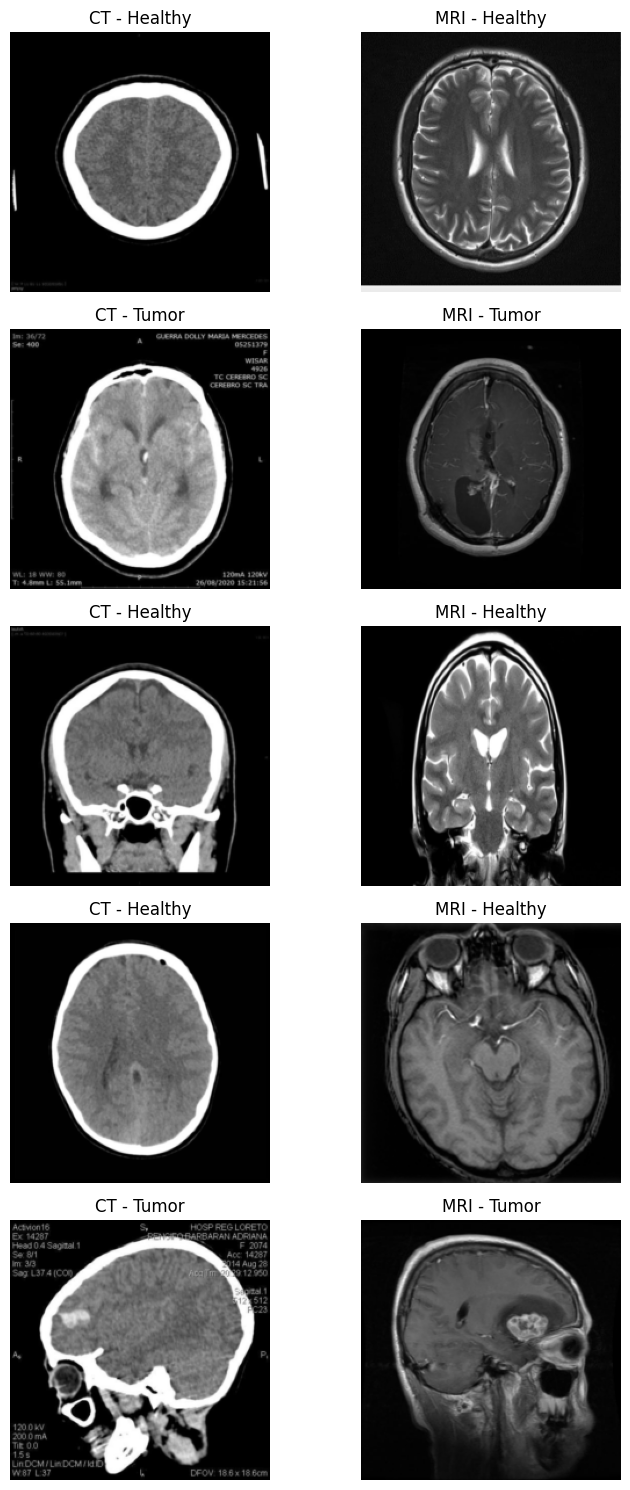

In [10]:
# Visualize a few CT-MRI pairs
import random
num_samples = 5
indices = random.sample(range(len(full_dataset)), num_samples)
fig, axs = plt.subplots(num_samples, 2, figsize=(8, 3 * num_samples))
for i, idx in enumerate(indices):
    (ct_img, mri_img), label = full_dataset[idx]
    axs[i, 0].imshow(ct_img.permute(1, 2, 0))
    axs[i, 0].set_title(f"CT - {'Tumor' if label == 1 else 'Healthy'}")
    axs[i, 1].imshow(mri_img.permute(1, 2, 0))
    axs[i, 1].set_title(f"MRI - {'Tumor' if label == 1 else 'Healthy'}")
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [11]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 4. Model Architecture
Define the dual-stream DenseNet model. Each branch processes CT or MRI separately, and their features are fused before classification.


In [12]:
class MultiModalDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        base_ct = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
        base_mri = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)

        for param in base_ct.features.parameters():
            param.requires_grad = False
        for param in base_mri.features.parameters():
            param.requires_grad = False

        self.ct_features = base_ct.features
        self.mri_features = base_mri.features

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(3840, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x_ct, x_mri):
        f_ct = self.ct_features(x_ct)
        f_mri = self.mri_features(x_mri)
        fused = torch.cat((f_ct, f_mri), dim=1)
        return self.classifier(fused)

# 5. Training Setup
Set the loss function and optimizer. Only the classifier is trained — the DenseNet feature extractors are frozen.



In [13]:
model = MultiModalDenseNet(num_classes=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5 

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 192MB/s]


In [14]:
# Initialize wandb
wandb.init(project='brain-tumour-classification',name= "densenet-training", config={
  "learning_rate": optimizer.param_groups[0]['lr'],
  "epochs": epochs,
  "batch_size": train_loader.batch_size
})

# 6. Training and Evaluation
Train for several epochs, print loss/accuracy, and evaluate on the validation set with metrics: confusion matrix and ROC-AUC.

In [15]:
def train_and_evaluate(model, train_loader, val_loader, epochs=5):
    best_auc = 0
    best_model_state = None

    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, train_acc = 0, 0
        for (ct, mri), labels in train_loader:
            ct, mri, labels = ct.to(device), mri.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(ct, mri)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (preds.argmax(1) == labels).float().mean().item()
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Validation phase (per epoch)
        model.eval()
        val_loss, val_acc = 0, 0
        all_labels, all_probs = [], []
        with torch.inference_mode():
            for (ct, mri), labels in val_loader:
                ct, mri, labels = ct.to(device), mri.to(device), labels.to(device)
                logits = model(ct, mri)
                loss = loss_fn(logits, labels)
                val_loss += loss.item()
                val_acc += (logits.argmax(1) == labels).float().mean().item()
                probs = torch.softmax(logits, dim=1)[:, 1]
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Calculate AUC
        auc = roc_auc_score(all_labels, all_probs)

        # Save best model
        if auc > best_auc:
            best_auc = auc
            best_model_state = model.state_dict()

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "val_auc": auc
        })

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Val AUC={auc:.4f}")

    # Load best model weights
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"\nBest model loaded (AUC = {best_auc:.4f})")

    # Final evaluation: Confusion Matrix & ROC
    model.eval()
    all_labels, all_probs = [], []
    with torch.inference_mode():
        for (ct, mri), labels in val_loader:
            ct, mri = ct.to(device), mri.to(device)
            logits = model(ct, mri)
            probs = torch.softmax(logits, dim=1)[:, 1]
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    preds = [1 if p >= 0.5 else 0 for p in all_probs]
    cm = confusion_matrix(all_labels, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Healthy', 'Tumour'])
    disp.plot(cmap='Blues')
    plt.title('Validation Confusion Matrix')
    plt.show()

    final_auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr, tpr, label=f'Final AUC = {final_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Final ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Log final AUC to wandb
    wandb.log({
        "final_val_auc": final_auc
    })


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.1530, Train Acc=0.9453 | Val Loss=0.0497, Val Acc=0.9861, Val AUC=0.9989
Epoch 2: Train Loss=0.0611, Train Acc=0.9795 | Val Loss=0.0350, Val Acc=0.9884, Val AUC=0.9995
Epoch 3: Train Loss=0.0452, Train Acc=0.9838 | Val Loss=0.0256, Val Acc=0.9919, Val AUC=0.9997
Epoch 4: Train Loss=0.0449, Train Acc=0.9823 | Val Loss=0.0268, Val Acc=0.9907, Val AUC=0.9995
Epoch 5: Train Loss=0.0246, Train Acc=0.9910 | Val Loss=0.0270, Val Acc=0.9931, Val AUC=0.9996

Best model loaded (AUC = 0.9997)


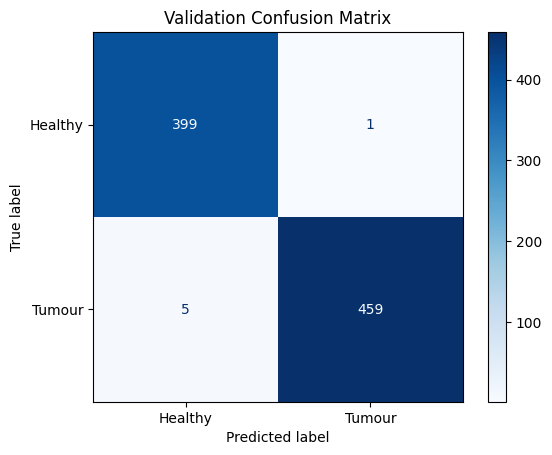

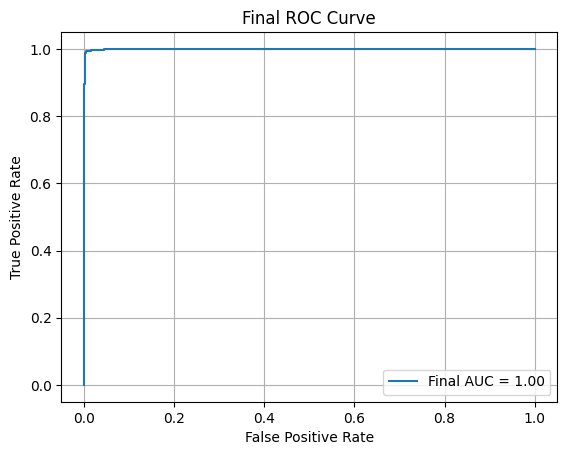

In [16]:
train_and_evaluate(model, train_loader, val_loader)

# 7. Saving the Model
Save the trained weights to a `.pth` file for use in inference or deployment.

In [17]:
torch.save(model.state_dict(), "multimodal_brain_tumor_model.pth")

In [19]:
artifact = wandb.Artifact(
    name="multimodal_brain_tumor_model",
    type="model",
    description="Best model state_dict for CT + MRI classifier",
    metadata={"framework": "pytorch", "format": "state_dict"}
)
artifact.add_file("/kaggle/working/multimodal_brain_tumor_model.pth")
wandb.log_artifact(artifact)


<Artifact multimodal_brain_tumor_model>

In [20]:
# Properly close the wandb session
wandb.finish()

epoch,▁▃▅▆█
final_val_auc,▁
train_acc,▁▆▇▇█
train_loss,█▃▂▂▁
val_acc,▁▃▇▆█
val_auc,▁▆█▆▇
val_loss,█▄▁▁▁
epoch,5
final_val_auc,0.99956
train_acc,0.99103
train_loss,0.02455


# 8. Upload to Hugging Face: Optional

Authenticate with your Hugging Face token and upload the saved model to your repository.

In [ ]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
HF_API_KEY = UserSecretsClient().get_secret("HF_TOKEN")

In [ ]:
login(token=HF_API_KEY)

In [ ]:
from huggingface_hub import HfApi

api = HfApi()
api.upload_file(
    path_or_fileobj="/kaggle/working/multimodal_brain_tumor_model.pth",
    path_in_repo="multimodal_brain_tumor_model.pth",
    repo_id="lukmanaj/brain-tumor-multimodal",
    repo_type="model"
)

Notebook complete. You can now use this trained model with the Streamlit app or for further analysis in other notebooks.
